In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
plt.style.use('ggplot')

import nltk

In [2]:
# Read in data
df = pd.read_csv('Tweets.csv', encoding='ISO-8859-1')
df_tester = pd.read_csv('Tweets.csv')
df = df.drop(['textID', 'selected_text'], axis=1)
df_tester.drop(['textID', 'selected_text'], axis=1)
df = df.head(5000)
df_tester = df_tester.head(5000)

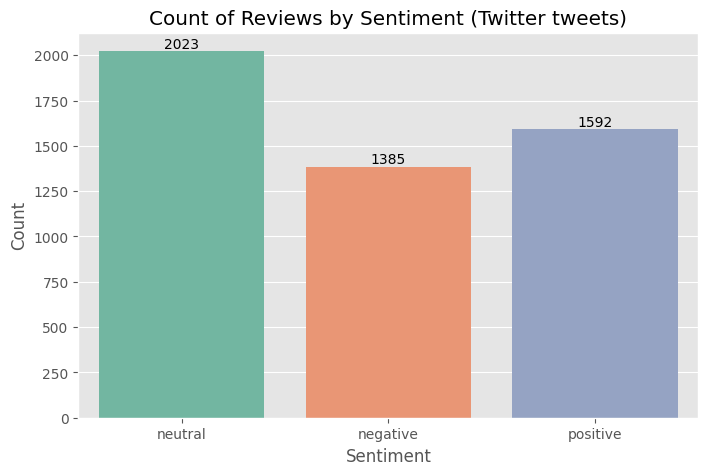

In [3]:
# Create a bar plot
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sentiment', palette='Set2')
plt.title('Count of Reviews by Sentiment (Twitter tweets)')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Annotate the bars with counts
for p in plt.gca().patches:
    plt.gca().annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

In [4]:
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [5]:
#data processing
import re, string
import emoji
import nltk

from tqdm.notebook import tqdm
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

In [6]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS
#Emojis will be left into the tweets as cardiffnlp is fine tuned
'''
#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text
'''

def clean(text):
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('<.*?>+', '', text)
    return text
    
#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2
'''
#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)
'''
def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [7]:
texts_new = []
for t in df.text:
    if pd.notna(t):  # Check if 't' is not NaN
        #cleaned_text = remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(str(t)))))
        cleaned_text = remove_mult_spaces(clean(clean_hashtags(str(t))))
        texts_new.append(cleaned_text)
    else:
        texts_new.append("")  # Replace NaN with an empty string


In [8]:
texts_new_test = []
for t in df_tester.text:
    if pd.notna(t):  # Check if 't' is not NaN
        #cleaned_text = remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(str(t)))))
        cleaned_text = remove_mult_spaces(clean(clean_hashtags(str(t))))
        texts_new_test.append(cleaned_text)
    else:
        texts_new_test.append("")  # Replace NaN with an empty string

In [9]:
df['text_cleaned'] = texts_new

In [10]:
df_tester['text_cleaned'] = texts_new_test

In [11]:
text_len = []
for text in df.text_cleaned:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [12]:
df['text_len'] = text_len

In [13]:
text_len_test = []
for text in df_tester.text_cleaned:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [14]:
df_tester['text_len'] = text_len

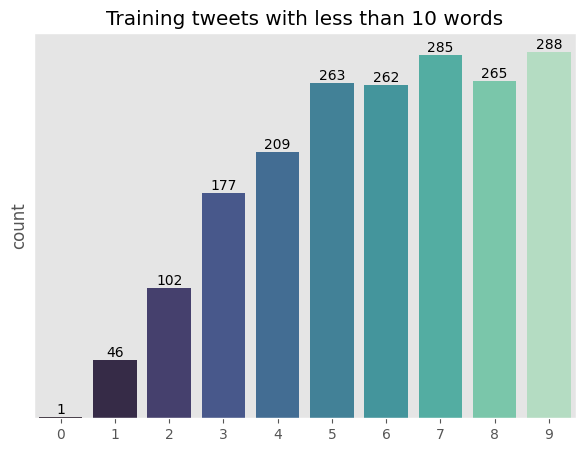

In [15]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

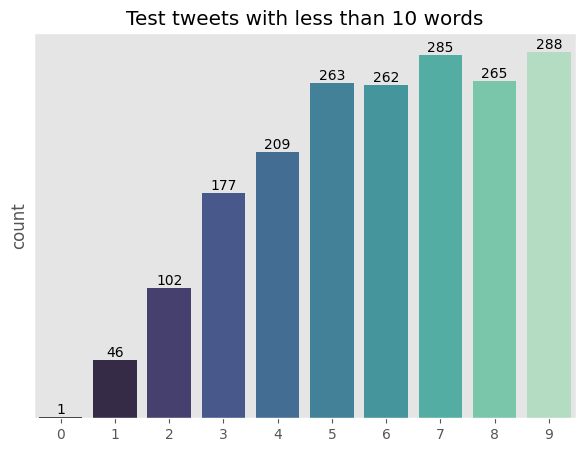

In [16]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_tester[df_tester['text_len']<10], palette='mako')
plt.title('Test tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [17]:
# Function to count words in a text
def count_words(text):
    words = text.split()
    return len(words)

# Apply the function to the 'Sentence' column and store the word counts in a new column
df['Word_Count'] = df['text_cleaned'].apply(count_words)


    

In [18]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_tester.shape}")

 DF SHAPE: (5000, 5)
 DF TEST SHAPE: (5000, 6)


In [19]:
df = df[df['text_len'] > 4]

In [20]:
df_tester = df_tester[df_tester['text_len'] > 4]

In [21]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_tester.shape}")

 DF SHAPE: (4465, 5)
 DF TEST SHAPE: (4465, 6)


In [22]:
df['sentiment'].value_counts()

sentiment
neutral     1759
positive    1426
negative    1280
Name: count, dtype: int64

In [23]:
df['sentiment'].value_counts()

sentiment
neutral     1759
positive    1426
negative    1280
Name: count, dtype: int64

In [24]:
df = df[['text','sentiment']]
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [25]:
df_tester = df_tester[['text','sentiment']]
df_tester.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [26]:
#analyzer = SentimentIntensityAnalyzer()

In [27]:
'''
def calculate_sentiment_scores(sentence):
    sntmnt = analyzer.polarity_scores(sentence)['compound']
    return(sntmnt)
'''

"\ndef calculate_sentiment_scores(sentence):\n    sntmnt = analyzer.polarity_scores(sentence)['compound']\n    return(sntmnt)\n"

In [28]:
'''
eng_snt_score =  []

for comment in df.text.to_list():
    snts_score = calculate_sentiment_scores(comment)
    eng_snt_score.append(snts_score)
'''

'\neng_snt_score =  []\n\nfor comment in df.text.to_list():\n    snts_score = calculate_sentiment_scores(comment)\n    eng_snt_score.append(snts_score)\n'

In [29]:
'''
df['sentiment_score'] = np.array(eng_snt_score)
df.head()
'''

"\ndf['sentiment_score'] = np.array(eng_snt_score)\ndf.head()\n"

In [30]:
'''
i = 0

vader_sentiment = [ ]

while(i<len(df)):
    if ((df.iloc[i]['sentiment_score'] >= 0.05)):
        vader_sentiment.append('positive')
        i = i+1
    elif ((df.iloc[i]['sentiment_score'] > -0.05) & (df.iloc[i]['sentiment_score'] < 0.05)):
        vader_sentiment.append('neutral')
        i = i+1
    elif ((df.iloc[i]['sentiment_score'] <= -0.05)):
        vader_sentiment.append('negative')
        i = i+1
'''

"\ni = 0\n\nvader_sentiment = [ ]\n\nwhile(i<len(df)):\n    if ((df.iloc[i]['sentiment_score'] >= 0.05)):\n        vader_sentiment.append('positive')\n        i = i+1\n    elif ((df.iloc[i]['sentiment_score'] > -0.05) & (df.iloc[i]['sentiment_score'] < 0.05)):\n        vader_sentiment.append('neutral')\n        i = i+1\n    elif ((df.iloc[i]['sentiment_score'] <= -0.05)):\n        vader_sentiment.append('negative')\n        i = i+1\n"

In [31]:
'''
df['vader_sentiment_labels'] = vader_sentiment
'''

"\ndf['vader_sentiment_labels'] = vader_sentiment\n"

In [32]:
'''
df.head(15)
'''

'\ndf.head(15)\n'

In [33]:
'''
df['actual_label'] = df['sentiment'].map({'positive': 1, 'neutral': 0, 'negative':-1})
df['predicted_label'] = df['vader_sentiment_labels'].map({'positive': 1, 'neutral': 0, 'negative':-1})

df.head()
'''

"\ndf['actual_label'] = df['sentiment'].map({'positive': 1, 'neutral': 0, 'negative':-1})\ndf['predicted_label'] = df['vader_sentiment_labels'].map({'positive': 1, 'neutral': 0, 'negative':-1})\n\ndf.head()\n"

In [34]:
'''
y_act = df['actual_label'].values
y_pred = df['predicted_label'].values
'''

"\ny_act = df['actual_label'].values\ny_pred = df['predicted_label'].values\n"

In [35]:
'''
from sklearn.metrics import classification_report
print('\tClassification Report for VADER:\n\n',classification_report(y_act,y_pred, target_names=['negative', 'neutral', 'positive']))
'''

"\nfrom sklearn.metrics import classification_report\nprint('\tClassification Report for VADER:\n\n',classification_report(y_act,y_pred, target_names=['negative', 'neutral', 'positive']))\n"

  0%|          | 0/4465 [00:00<?, ?it/s]

Positive F1 Score: 0.6601650412603152
Neutral F1 Score: 0.8518899460015429
Negative F1 Score: 0.8670388226338492
Positive Sentiments Count: 2265
Neutral Sentiments Count: 1152
Negative Sentiments Count: 1048


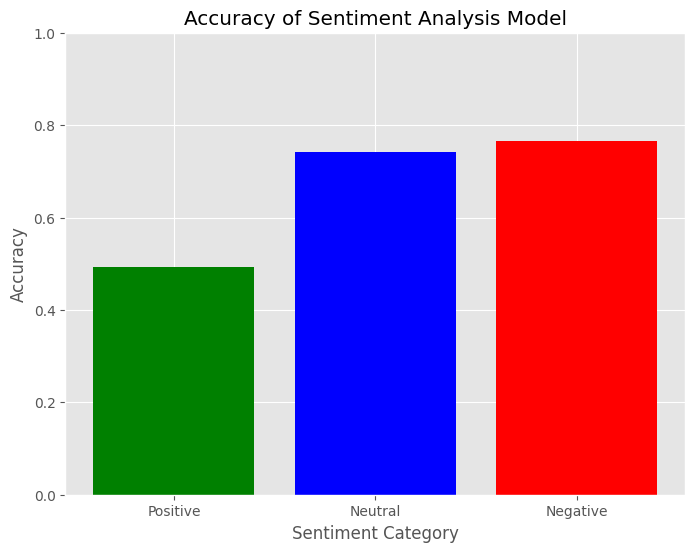

In [36]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import f1_score, accuracy_score
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# Define a function to calculate sentiment scores and labels
def calculate_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)
    compound_score = sentiment['compound']
    
    if compound_score >= 0.1:
        return 1  # Positive sentiment
    elif compound_score <= -0.1:
        return -1  # Negative sentiment
    else:
        return 0  # Neutral sentiment

# Assuming you have already loaded the 'df' DataFrame and cleaned 'text' as 'texts_new'

# Calculate sentiment scores and labels for 'texts_new'
#sentiment_labels = [calculate_sentiment(text) for text in tqdm(texts_new)]
sentiment_labels = [calculate_sentiment(text) for text in tqdm(df['text'])]
# Add sentiment labels to the DataFrame 'df'
df['sentiment'] = sentiment_labels

# Calculate F1 scores
positive_f1 = f1_score(df['sentiment'] == 'Positive', df['sentiment'] == 1, average='weighted')
neutral_f1 = f1_score(df['sentiment'] == 'Neutral', df['sentiment'] == 0, average='weighted')
negative_f1 = f1_score(df['sentiment'] == 'Negative', df['sentiment'] == -1, average='weighted')

print("Positive F1 Score:", positive_f1)
print("Neutral F1 Score:", neutral_f1)
print("Negative F1 Score:", negative_f1)

# Print the counts of positive, neutral, and negative sentiments
positive_count = (df['sentiment'] == 1).sum()
neutral_count = (df['sentiment'] == 0).sum()
negative_count = (df['sentiment'] == -1).sum()

print("Positive Sentiments Count:", positive_count)
print("Neutral Sentiments Count:", neutral_count)
print("Negative Sentiments Count:", negative_count)

# Calculate accuracy for each sentiment category
positive_accuracy = accuracy_score(df['sentiment'] == 'Positive', df['sentiment'] == 1)
neutral_accuracy = accuracy_score(df['sentiment'] == 'Neutral', df['sentiment'] == 0)
negative_accuracy = accuracy_score(df['sentiment'] == 'Negative', df['sentiment'] == -1)



# Create a bar plot to visualize accuracy
categories = ['Positive', 'Neutral', 'Negative']
accuracies = [positive_accuracy, neutral_accuracy, negative_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(categories, accuracies, color=['green', 'blue', 'red'])
plt.xlabel('Sentiment Category')
plt.ylabel('Accuracy')
plt.title('Accuracy of Sentiment Analysis Model')
plt.ylim(0, 1)  # Set the y-axis limits between 0 and 1
plt.show()




In [45]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Analyze the sentiment of your text
sentiment_scores = analyzer.polarity_scores('i was there so you should go in my place brandwkshop i see theyve got scott bedbury and more poor me')
compound_score = sentiment_scores['compound']

print(compound_score)

-0.5256


In [44]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Analyze the sentiment of your text
sentiment_scores = analyzer.polarity_scores('loves her mum very much happy mothers day to all the wonderful mothers out there')
compound_score = sentiment_scores['compound']

print(compound_score)

0.9077


In [37]:
print(positive_accuracy)
print(negative_accuracy)
print(neutral_accuracy)

0.49272116461366183
0.7652855543113102
0.741993281075028


In [38]:
# Initialize lists to store the top three for each category
top_three_negative = []
top_three_positive = []
top_three_neutral = []

for text in df['text']:
    sentiment_scores = analyzer.polarity_scores(text)
    compound_score = sentiment_scores['compound']

    # Check if it's in the top three most negative, positive, or neutral sentiments
    if compound_score < 0:
        top_three_negative.append((text, sentiment_scores, compound_score))
    elif compound_score > 0:
        top_three_positive.append((text, sentiment_scores, compound_score))
    else:
        top_three_neutral.append((text, sentiment_scores, compound_score))

# Sort the lists by the compound score
top_three_negative = sorted(top_three_negative, key=lambda x: x[2])[:3]
top_three_positive = sorted(top_three_positive, key=lambda x: x[2], reverse=True)[:3]
top_three_neutral = sorted(top_three_neutral, key=lambda x: x[2], reverse=True)[:3]

# Print the top three for each category along with their scores
print("Top Three Most Negative:")
for i, (text, scores, compound_score) in enumerate(top_three_negative, start=1):
    print(f"{i}. Score: {compound_score:.4f}")
    print("   Positive: {:.4f}, Negative: {:.4f}, Neutral: {:.4f}".format(scores['pos'], scores['neg'], scores['neu']))
    print(f"   Text: {text}\n")

print("\nTop Three Most Positive:")
for i, (text, scores, compound_score) in enumerate(top_three_positive, start=1):
    print(f"{i}. Score: {compound_score:.4f}")
    print("   Positive: {:.4f}, Negative: {:.4f}, Neutral: {:.4f}".format(scores['pos'], scores['neg'], scores['neu']))
    print(f"   Text: {text}\n")

print("\nTop Three Most Neutral:")
for i, (text, scores, compound_score) in enumerate(top_three_neutral, start=1):
    print(f"{i}. Score: {compound_score:.4f}")
    print("   Positive: {:.4f}, Negative: {:.4f}, Neutral: {:.4f}".format(scores['pos'], scores['neg'], scores['neu']))
    print(f"   Text: {text}\n")

NameError: name 'analyzer' is not defined

In [39]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import f1_score, accuracy_score
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# Define a function to calculate sentiment scores and labels using VADER
def calculate_sentiment_vader(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)
    compound_score = sentiment['compound']

    if compound_score >= 0.1:
        return 'Positive'
    elif compound_score <= -0.1:
        return 'Negative'
    else:
        return 'Neutral'

# Assuming you have already loaded the 'df' DataFrame and cleaned 'text' as 'texts_new'

# Calculate sentiment labels using VADER for 'texts_new'
sentiment_labels_vader = [calculate_sentiment_vader(text) for text in tqdm(df['text'])]

# Add VADER sentiment labels to the DataFrame 'df'
df['sentiment_vader'] = sentiment_labels_vader

# Now, calculate RoBERTa sentiment scores using your RoBERTa model
# Replace this with your RoBERTa model's prediction code

# Initialize lists to store the top three for each category
top_three_negative = []
top_three_positive = []
top_three_neutral = []

for i, prediction in enumerate(result_roberta):
    sentiment_score = prediction  # Assuming your RoBERTa model returns sentiment scores

    # Determine the sentiment label based on your RoBERTa model's threshold or criteria
    if sentiment_score > threshold:
        sentiment_label = 'Positive'
    elif sentiment_score < -threshold:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'

    # Check if it's in the top three most negative, positive, or neutral sentiments
    if sentiment_label == 'Negative':
        top_three_negative.append((df['text'].iloc[i], sentiment_score))
    elif sentiment_label == 'Positive':
        top_three_positive.append((df['text'].iloc[i], sentiment_score))
    else:
        top_three_neutral.append((df['text'].iloc[i], sentiment_score))

# Sort the lists by sentiment score
top_three_negative = sorted(top_three_negative, key=lambda x: x[1])[:3]
top_three_positive = sorted(top_three_positive, key=lambda x: x[1], reverse=True)[:3]
top_three_neutral = sorted(top_three_neutral, key=lambda x: x[1], reverse=True)[:3]

# Print the top three for each category along with their scores
print("Top Three Most Negative:")
for i, (text, score) in enumerate(top_three_negative, start=1):
    print(f"{i}. Score: {score:.4f}")
    print(f"   Text: {text}\n")

print("\nTop Three Most Positive:")
for i, (text, score) in enumerate(top_three_positive, start=1):
    print(f"{i}. Score: {score:.4f}")
    print(f"   Text: {text}\n")

print("\nTop Three Most Neutral:")
for i, (text, score) in enumerate(top_three_neutral, start=1):
    print(f"{i}. Score: {score:.4f}")
    print(f"   Text: {text}\n")

# Continue with your F1 score and accuracy calculations, and visualization


  0%|          | 0/4465 [00:00<?, ?it/s]

NameError: name 'result_roberta' is not defined

In [50]:
# Initialize lists to store the top three for each category
top_three_negative = []
top_three_positive = []
top_three_neutral = []

for text in df['text']:
    sentiment_scores = analyzer.polarity_scores(text)
    compound_score = sentiment_scores['compound']

    # Check if it's in the top three most negative, positive, or neutral sentiments
    if compound_score < 0:
        top_three_negative.append((text, sentiment_scores, compound_score))
    elif compound_score > 0:
        top_three_positive.append((text, sentiment_scores, compound_score))
    else:
        top_three_neutral.append((text, sentiment_scores, compound_score))

# Sort the lists by the compound score
top_three_negative = sorted(top_three_negative, key=lambda x: x[2])[:3]
top_three_positive = sorted(top_three_positive, key=lambda x: x[2], reverse=True)[:3]
top_three_neutral = sorted(top_three_neutral, key=lambda x: x[2], reverse=True)[:3]

# Print the top three for each category along with their scores
print("Top Three Most Negative:")
for i, (text, scores, compound_score) in enumerate(top_three_negative, start=1):
    print(f"{i}. Score: {compound_score:.4f}")
    print("   Positive: {:.4f}, Negative: {:.4f}, Neutral: {:.4f}".format(scores['pos'], scores['neg'], scores['neu']))
    print(f"   Text: {text}\n")

print("\nTop Three Most Positive:")
for i, (text, scores, compound_score) in enumerate(top_three_positive, start=1):
    print(f"{i}. Score: {compound_score:.4f}")
    print("   Positive: {:.4f}, Negative: {:.4f}, Neutral: {:.4f}".format(scores['pos'], scores['neg'], scores['neu']))
    print(f"   Text: {text}\n")

print("\nTop Three Most Neutral:")
for i, (text, scores, compound_score) in enumerate(top_three_neutral, start=1):
    print(f"{i}. Score: {compound_score:.4f}")
    print("   Positive: {:.4f}, Negative: {:.4f}, Neutral: {:.4f}".format(scores['pos'], scores['neg'], scores['neu']))
    print(f"   Text: {text}\n")

Top Three Most Negative:
1. Score: -0.9400
   Positive: 0.0000, Negative: 0.4800, Neutral: 0.5200
   Text: Argh noo! Missed The Killers on Wossy!  That sucks! Missed out on Brandon. Total failure! Anyone know if it`s repeated? Must investigate!

2. Score: -0.9311
   Positive: 0.0760, Negative: 0.4250, Neutral: 0.4990
   Text:  sorryyy milerz that i can`t vote i would love to vote but it doesn`t works i`m sad  and very frustraded  :@ :@ --__--

3. Score: -0.9266
   Positive: 0.0000, Negative: 0.5100, Neutral: 0.4900
   Text: How did I give birth to a SCREAMER?? I hate screaming children!! I guess I hate screaming children besides my own, now.


Top Three Most Positive:
1. Score: 0.9750
   Positive: 0.5940, Negative: 0.0000, Neutral: 0.4060
   Text: Toris was SO fun! JB MOVIE WAS ABSOLUTELY AMAZING! and i had a good day at work!  YAY i loved the movie! :0

2. Score: 0.9709
   Positive: 0.6440, Negative: 0.0000, Neutral: 0.3560
   Text: Wonderful weekend  I love my family  & friends becau

In [47]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import f1_score, accuracy_score
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# Initialize the VADER sentiment analyzer at the global level
analyzer = SentimentIntensityAnalyzer()

# Define a function to calculate sentiment scores and labels using VADER
def calculate_sentiment_vader(text):
    sentiment = analyzer.polarity_scores(text)
    compound_score = sentiment['compound']
    
    if compound_score >= 0.1:
        return 'Positive'
    elif compound_score <= -0.1:
        return 'Negative'
    else:
        return 'Neutral'

# Assuming you have already loaded the 'df' DataFrame and cleaned 'text' as 'texts_new'

# Calculate sentiment scores and labels using VADER for 'texts_new'
sentiment_labels_vader = [calculate_sentiment_vader(text) for text in tqdm(df['text'])]

# Add VADER sentiment labels to the DataFrame 'df'
df['sentiment_vader'] = sentiment_labels_vader

# Calculate F1 scores
positive_f1_vader = f1_score(df['sentiment'] == 'Positive', df['sentiment_vader'] == 'Positive', average='weighted')
neutral_f1_vader = f1_score(df['sentiment'] == 'Neutral', df['sentiment_vader'] == 'Neutral', average='weighted')
negative_f1_vader = f1_score(df['sentiment'] == 'Negative', df['sentiment_vader'] == 'Negative', average='weighted')

print("Positive F1 Score (VADER):", positive_f1_vader)
print("Neutral F1 Score (VADER):", neutral_f1_vader)
print("Negative F1 Score (VADER):", negative_f1_vader)

# Calculate accuracy for each sentiment category
positive_accuracy_vader = accuracy_score(df['sentiment'] == 'Positive', df['sentiment_vader'] == 'Positive')
neutral_accuracy_vader = accuracy_score(df['sentiment'] == 'Neutral', df['sentiment_vader'] == 'Neutral')
negative_accuracy_vader = accuracy_score(df['sentiment'] == 'Negative', df['sentiment_vader'] == 'Negative')

print("Positive Accuracy (VADER):", positive_accuracy_vader)
print("Neutral Accuracy (VADER):", neutral_accuracy_vader)
print("Negative Accuracy (VADER):", negative_accuracy_vader)

# Continue with your code for the top three most negative, positive, and neutral sentiments


  0%|          | 0/4465 [00:00<?, ?it/s]

Positive F1 Score (VADER): 0.6601650412603152
Neutral F1 Score (VADER): 0.8518899460015429
Negative F1 Score (VADER): 0.8670388226338492
Positive Accuracy (VADER): 0.49272116461366183
Neutral Accuracy (VADER): 0.741993281075028
Negative Accuracy (VADER): 0.7652855543113102


In [48]:
print("Positive Accuracy Score:", positive_accuracy)
print("Neutral Accuracy Score:", neutral_accuracy)
print("Negative Accuracy Score:", negative_accuracy)

Positive Accuracy Score: 0.49272116461366183
Neutral Accuracy Score: 0.741993281075028
Negative Accuracy Score: 0.7652855543113102


In [49]:

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm

# Assuming you have already loaded the 'df' DataFrame and performed the sentiment analysis

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Calculate sentiment scores for the entire dataset and assign a unique identifier ('num') to each row
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    clean_comment = row['clean_comment']
    mynum = i  # Use the index of the DataFrame as the unique identifier
    
    # Handle NaN values by replacing them with an empty string
    if pd.notna(clean_comment):
        res[mynum] = analyzer.polarity_scores(clean_comment)
    else:
        res[mynum] = {'compound': 0.0}  # You can use 0.0 or another appropriate value

# Convert sentiment scores to sentiment labels (positive, neutral, negative)
def sentiment_label(compound_score):
    if compound_score >= 0.05:
        return 1
    elif compound_score <= -0.05:
        return -1
    else:
        return 0

vaders = pd.DataFrame(res).T
vaders['category'] = vaders['compound'].apply(sentiment_label)

# Calculate F1 score for each sentiment class
positive_f1 = f1_score(df['category'] == 1, vaders['category'] == 1, average='weighted')
neutral_f1 = f1_score(df['category'] == 0, vaders['category'] == 0, average='weighted')
negative_f1 = f1_score(df['category'] == -1, vaders['category'] == -1, average='weighted')

print("Positive F1 Score:", positive_f1)
print("Neutral F1 Score:", neutral_f1)
print("Negative F1 Score:", negative_f1)

# Print the counts of positive, neutral, and negative sentiments
positive_count = (vaders['category'] == 1).sum()
neutral_count = (vaders['category'] == 0).sum()
negative_count = (vaders['category'] == -1).sum()

print("Positive Sentiments Count:", positive_count)
print("Neutral Sentiments Count:", neutral_count)
print("Negative Sentiments Count:", negative_count)

# Calculate accuracy for each sentiment category
positive_accuracy = accuracy_score(df['category'] == 1, vaders['category'] == 1)
neutral_accuracy = accuracy_score(df['category'] == 0, vaders['category'] == 0)
negative_accuracy = accuracy_score(df['category'] == -1, vaders['category'] == -1)

# Create a bar plot to visualize accuracy
categories = ['Positive', 'Neutral', 'Negative']
accuracies = [positive_accuracy, neutral_accuracy, negative_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(categories, accuracies, color=['green', 'blue', 'red'])
plt.xlabel('Sentiment Category')
plt.ylabel('Accuracy')
plt.title('Accuracy of Sentiment Analysis Model')
plt.ylim(0, 1)  # Set the y-axis limits between 0 and 1
plt.show()

  0%|          | 0/4465 [00:00<?, ?it/s]

KeyError: 'clean_comment'

In [ ]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
 
analyzer = SentimentIntensityAnalyzer()


def vader_sentiment_result(df):
    df = str(df)
    scores = analyzer.polarity_scores(df)
    if scores["compound"] >= 0.05:
        return 1  # Positive
    if scores["compound"] <= -0.05:
        return -1  # Negative
    if (scores["compound"] > -0.05) and (scores["compound"] < 0.05):
        return 0  # Neutral
 
score_vader = df['clean_comment'].apply(lambda i: vader_sentiment_result(i))
score_vader.value_counts()

In [ ]:
from sklearn.metrics import f1_score, classification_report
# Assuming 'score_vader' contains your new sentiment results
original_sentiment = df['category']
# Calculate the F1 score for each sentiment class
f1_positive = f1_score(original_sentiment, score_vader == 1, average='weighted')
f1_negative = f1_score(original_sentiment, score_vader == -1, average='weighted')
f1_neutral = f1_score(original_sentiment, score_vader == 0, average='weighted')

# Print the F1 scores
print("F1 Score for Positive Sentiment:", f1_positive)
print("F1 Score for Negative Sentiment:", f1_negative)
print("F1 Score for Neutral Sentiment:", f1_neutral)

# Generate a classification report for detailed metrics
classification_rep = classification_report(original_sentiment, score_vader, target_names=['Negative', 'Neutral', 'Positive'])
print("Classification Report:\n", classification_rep)
